In [1]:
# adapted from https://github.com/sksq96/pytorch-vae/blob/master/vae-cnn.ipynb

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
import torchvision.transforms as T

import torchvision
from torchvision import datasets
from torchvision import transforms
from torchvision.utils import save_image
import sys
# from torchsummary import summary

# from pushover import notify
# from utils import makegif
from random import randint

from IPython.display import Image
from IPython.core.display import Image, display

from matplotlib import pyplot as plt

import pickle

%load_ext autoreload
%autoreload 2

/home/x4nno/.local/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/tmp/ipykernel_9983/3648496838.py:21: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import Image, display


In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
bs = 32

# create our data
SCALE = False
VERBOSE = False
CHAIN = False

load_dataset = False

sys.path.append("/home/x4nno/Documents/PhD/FRACOs_v3/utils")
from VAE_creation import generate_VAE_training_environments, custom_dataset

if not load_dataset:

    _, train_dataset_pre = generate_VAE_training_environments(number_of_environments=300,
                                                              flat=False, scale=SCALE,
                                                              remove_agent=True,
                                                              remove_goal=True,
                                                              chain_stack=CHAIN)
    
    print("created train datasets")
    
    _, test_dataset_pre = generate_VAE_training_environments(number_of_environments=100,
                                                              flat=False, scale=SCALE,
                                                              remove_agent=True,
                                                              remove_goal=True,
                                                              chain_stack=CHAIN)
    
    print("created test datasets")
    
    pickle.dump(train_dataset_pre, open("vae_train_dataset_pre.p", "wb"))
    pickle.dump(test_dataset_pre, open("vae_test_dataset_pre.p", "wb"))
    
else:
    train_dataset_pre = pickle.load(open("vae_train_dataset_pre.p", "rb"))
    test_dataset_pre = pickle.load(open("vae_test_dataset_pre.p", "rb"))

created train datasets
created test datasets


In [3]:
import numpy as np 

In [4]:
train_dataset_pre = np.asarray(train_dataset_pre)

In [5]:
train_dataset_pre.shape

(8966, 1, 7, 7)

In [6]:
train_dataset = custom_dataset(train_dataset_pre)
test_dataset = custom_dataset(test_dataset_pre)

dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=bs, shuffle=True)

In [7]:
fixed_x, _ = next(iter(dataloader))

In [8]:
fixed_x.shape

torch.Size([32, 1, 7, 7])

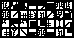

In [9]:
save_image(fixed_x, 'real_image.png')
Image('real_image.png') # this just doesn't work as it's not supporting 0 and 1 inputs

In [10]:
image_prod = next(iter(fixed_x))
save_image(image_prod, 'real_image.png')
Image('real_image.png')

In [11]:
class Flatten(nn.Module):
    def forward(self, input):
        return input.view(input.size(0), -1)

In [12]:
class UnFlatten(nn.Module):
    def forward(self, input, size=1024):
        return input.view(input.size(0), size, 1, 1)

In [24]:
class VAE(nn.Module):
    def __init__(self, image_channels=1, h_dim=1024, z_dim=32):
        super(VAE, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(image_channels, 32, kernel_size=2, stride=2),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=2, stride=2),
            nn.ReLU(),
            nn.Conv2d(64, 128, kernel_size=2, stride=2),
            nn.ReLU(),
            nn.Conv2d(128, 256, kernel_size=2, stride=2),
            nn.ReLU(),
            Flatten()
        )
        
        self.fc1 = nn.Linear(h_dim, z_dim)
        self.fc2 = nn.Linear(h_dim, z_dim)
        self.fc3 = nn.Linear(z_dim, h_dim)
        
        self.decoder = nn.Sequential(
            UnFlatten(),
            nn.ConvTranspose2d(h_dim, 128, kernel_size=2, stride=2),
            nn.ReLU(),
            nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, kernel_size=2, stride=2),
            nn.ReLU(),
            nn.ConvTranspose2d(32, image_channels, kernel_size=2, stride=2),
            nn.Sigmoid(),
        )
        
    def reparameterize(self, mu, logvar):
        std = logvar.mul(0.5).exp_()
        # return torch.normal(mu, std)
        esp = torch.randn(*mu.size())
        z = mu + std * esp
        return z
    
    def bottleneck(self, h):
        mu, logvar = self.fc1(h), self.fc2(h)
        z = self.reparameterize(mu, logvar)
        return z, mu, logvar

    def encode(self, x):
        h = self.encoder(x)
        z, mu, logvar = self.bottleneck(h)
        return z, mu, logvar

    def decode(self, z):
        z = self.fc3(z)
        z = self.decoder(z)
        return z

    def forward(self, x):
        z, mu, logvar = self.encode(x)
        z = self.decode(z)
        return z, mu, logvar

In [25]:
image_channels = fixed_x.size(1)
image_channels

1

In [26]:
model = VAE(image_channels=image_channels).to(device)
# model.load_state_dict(torch.load('vae.torch', map_location='cpu'))

In [27]:
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3) 

In [28]:
def loss_fn(recon_x, x, mu, logvar):
    BCE = F.binary_cross_entropy(recon_x, x, size_average=False)
    # BCE = F.mse_loss(recon_x, x, size_average=False)

    # see Appendix B from VAE paper:
    # Kingma and Welling. Auto-Encoding Variational Bayes. ICLR, 2014
    # 0.5 * sum(1 + log(sigma^2) - mu^2 - sigma^2)
    KLD = -0.5 * torch.mean(1 + logvar - mu.pow(2) - logvar.exp())

    return BCE + KLD, BCE, KLD

In [29]:
!rm -rfr reconstructed
!mkdir reconstructed

In [30]:
epochs = 50

In [31]:
for epoch in range(epochs):
    for idx, (images, _) in enumerate(dataloader):
        recon_images, mu, logvar = model(images.to(device))
        loss, bce, kld = loss_fn(recon_images, images, mu, logvar)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        to_print = "Epoch[{}/{}] Loss: {:.3f} {:.3f} {:.3f}".format(epoch+1, 
                                epochs, loss.data[0]/bs, bce.data[0]/bs, kld.data[0]/bs)
        print(to_print)


torch.save(model.state_dict(), 'vae.torch')

RuntimeError: Calculated padded input size per channel: (1 x 1). Kernel size: (2 x 2). Kernel size can't be greater than actual input size